In [2]:
from xgboost.testing.data import joblib
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Pfad zum Projekt-Root hinzufügen, um das Package 'src' zu finden
# Annahme: Dieses Notebook liegt in src/notebooks/
import sys
from pathlib import Path

from tqdm import tqdm



In [3]:
# custom imports
PROJECT_ROOT = Path(__file__).resolve().parent.parent.parent if "__file__" in locals() else Path("../../..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.d_eval.evaluation.loader import load_model
from src.d_eval.evaluation.style import apply_shap_style, save_plot
from src.c_tuning_training.hpo_pipeline.data_loader import DataLoader

apply_shap_style()


def save_shap_results(results_dict, folder="shap_export"):
    if not os.path.exists(folder):
        os.makedirs(folder)

    for name, data in results_dict.items():
        # 1. SHAP Values speichern (Numpy)
        np.save(f"{folder}/{name}_values.npy", data["values"])

        # 2. X_explain speichern (Pandas)
        data["data"].to_csv(f"{folder}/{name}_data.csv")

        # 3. Explainer speichern
        # TreeExplainer haben eine interne save-Methode
        try:
            with open(f"{folder}/{name}_explainer.pkl", "wb") as f:
                joblib.dump(data["explainer"], f)
        except Exception as e:
            print(f"Warnung: Explainer für {name} konnte nicht gepickelt werden. "
                  f"Die Values sind aber unter {name}_values.npy sicher.")

    print(f"--- Export in '{folder}' abgeschlossen ---")


def load_shap_results(names, folder="shap_export"):
    loaded_results = {}
    for name in names:
        loaded_results[name] = {
            "values": np.load(f"{folder}/{name}_values.npy"),
            "data": pd.read_csv(f"{folder}/{name}_data.csv", index_col=0),
            "explainer": joblib.load(f"{folder}/{name}_explainer.pkl")
        }
    return loaded_results


In [4]:
# paths
DATA_DIR = "/Users/robin/PycharmProjects/Masterarbeit_Public/data/parquet/features/asinh1-reg"
TRAIN_SET_PATH = DATA_DIR + "/splits/train.parquet"
VAL_SET_PATH = DATA_DIR + "/splits/val_purged.parquet"
SCALER_PATH = DATA_DIR + "/scaler/scaler.joblib"

# models
MLP_PATH = "/Users/robin/PycharmProjects/Masterarbeit_Public/models/MLP.joblib"
RF_PATH = "/Users/robin/PycharmProjects/Masterarbeit_Public/models/RandomForest.joblib"
CB_PATH = "/Users/robin/PycharmProjects/Masterarbeit_Public/models/CatBoostGPU.joblib"

# figures path
FIGURES_PATH = "figures/blackbox/"

# data
TTD_MINUTES_MAX = 300
TTD_MINUTES_MIN = 30

# target
TARGET_COL = "label_5min"
THINNING_FREQ_MIN = 5


In [5]:
# load train data
loader = DataLoader({}, train_path=TRAIN_SET_PATH)
X_train_scaled, y_train_scaled = loader.load_train_data(
    target_col=TARGET_COL,
    keep_id_cols=False,
    sample_n=20000,
    features_blacklist_keywords=["label_"]
)

if TTD_MINUTES_MAX or TTD_MINUTES_MIN:
    print(f"Clipping TTD window to range: {TTD_MINUTES_MIN} - {TTD_MINUTES_MAX} minutes")
    ttd_minutes = (X_train_scaled["delivery_start"] - X_train_scaled["snapshot_times"]).dt.total_seconds() / 60
    ttd_min_mask = ttd_minutes > TTD_MINUTES_MIN if TTD_MINUTES_MIN is not None else True
    ttd_max_mask = ttd_minutes < TTD_MINUTES_MAX if TTD_MINUTES_MAX is not None else True
    print(
        f"Rows to be clipped based on TTD min: {(~ttd_min_mask).sum()} / {len(X_train_scaled)} ({((~ttd_min_mask).sum() / len(X_train_scaled)) * 100:.2f}%)")
    print(
        f"Rows to be clipped based on TTD max: {(~ttd_max_mask).sum()} / {len(X_train_scaled)} ({((~ttd_max_mask).sum() / len(X_train_scaled)) * 100:.2f}%)")
    X_train_scaled = X_train_scaled[ttd_min_mask & ttd_max_mask]
    y_train_scaled = X_train_scaled[ttd_min_mask & ttd_max_mask]
    print(f"Data shape after clipping TTD window: {X_train_scaled.shape}")
else:
    print("No TTD clipping applied.")


Memory usage of dataframe is 4702.56 MB
Memory usage after optimization is: 2159.34 MB
Decreased by 54.1%
Clipping TTD window to range: 30 - 300 minutes
Rows to be clipped based on TTD min: 1764 / 19488 (9.05%)
Rows to be clipped based on TTD max: 0 / 19488 (0.00%)
Data shape after clipping TTD window: (17724, 79)


/var/folders/_g/t9jm9x4n7v313q5_zspldllr0000gn/T/ipykernel_2351/2849134858.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y_train_scaled = X_train_scaled[ttd_min_mask & ttd_max_mask]


In [6]:
# load test data
from src.d_eval.evaluation.loader import load_test_data_v2

X_test_scaled, y_test_scaled = load_test_data_v2(
    VAL_SET_PATH,
    target_col=TARGET_COL,
    keep_id_cols=True,
    sample_minutes=THINNING_FREQ_MIN
)

# extract product keys for later use
product_keys = X_test_scaled['delivery_start']
snapshot_times = X_test_scaled['snapshot_times']
ttd_min = (product_keys - snapshot_times).dt.total_seconds() / 60

if TTD_MINUTES_MAX or TTD_MINUTES_MIN:
    print(f"Clipping TTD window to range: {TTD_MINUTES_MIN} - {TTD_MINUTES_MAX} minutes")
    ttd_minutes = (X_test_scaled["delivery_start"] - X_test_scaled["snapshot_times"]).dt.total_seconds() / 60
    ttd_min_mask = ttd_minutes > TTD_MINUTES_MIN if TTD_MINUTES_MIN is not None else True
    ttd_max_mask = ttd_minutes < TTD_MINUTES_MAX if TTD_MINUTES_MAX is not None else True
    print(
        f"Rows to be clipped based on TTD min: {(~ttd_min_mask).sum()} / {len(X_test_scaled)} ({((~ttd_min_mask).sum() / len(X_test_scaled)) * 100:.2f}%)")
    print(
        f"Rows to be clipped based on TTD max: {(~ttd_max_mask).sum()} / {len(X_test_scaled)} ({((~ttd_max_mask).sum() / len(X_test_scaled)) * 100:.2f}%)")
    X_test_scaled = X_test_scaled[ttd_min_mask & ttd_max_mask]
    y_test_scaled = y_test_scaled[ttd_min_mask & ttd_max_mask]
    print(f"Data shape after clipping TTD window: {X_test_scaled.shape}")
else:
    print("No TTD clipping applied.")

# drop id cols from features
X_test = X_test_scaled.drop(columns=['delivery_start', "snapshot_times"])

print("-" * 30)
print(f"Anzahl Test-Samples (nach Downsampling): {len(y_test_scaled):,}")

Memory usage of dataframe is 1496.47 MB
Memory usage after optimization is: 1450.66 MB
Decreased by 3.1%
Downsampling (Relativ 5min): Von 4,002,956 auf 142,153 Zeilen reduziert.
No TTD clipping applied.
Clipping TTD window to range: 30 - 300 minutes
Rows to be clipped based on TTD min: 12601 / 142153 (8.86%)
Rows to be clipped based on TTD max: 0 / 142153 (0.00%)
Data shape after clipping TTD window: (129552, 79)
------------------------------
Anzahl Test-Samples (nach Downsampling): 129,552


In [7]:
# load model
model_mlp = load_model(MLP_PATH)
model_cb = load_model(CB_PATH)
model_rf = load_model(RF_PATH)

/opt/anaconda3/envs/Masterarbeit/lib/python3.12/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Fixing missing 'multi_class' attribute for MLPRegressor...


/opt/anaconda3/envs/Masterarbeit/lib/python3.12/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/envs/Masterarbeit/lib/python3.12/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [8]:
from joblib import Parallel, delayed
import os
import shap
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm


def calculate_shap_regression(model, X_train_clean, X_explain, model_type="tree", n_jobs=-1):
    print(f"--- Processing {type(model).__name__} ({model_type}) ---")

    # 1. TREE MODELS (RF, CatBoost, XGBoost)
    if model_type == "tree":
        # TreeExplainer ist nativ für Regression optimiert
        explainer = shap.TreeExplainer(model)
        # Bei Regression gibt TreeExplainer direkt ein (n_samples, n_features) Array zurück
        vals = explainer.shap_values(X_explain)
        return explainer, vals

    # 2. MLP / KERNEL MODELS (Parallelisiert)
    elif model_type == "kernel":
        # Hintergrund-Repräsentanten (K-Means) zur Beschleunigung
        background = shap.kmeans(X_train_clean, 50)
        explainer = shap.KernelExplainer(model.predict, background)

        n_cores = os.cpu_count()
        n_jobs_real = n_cores - 1 if n_jobs <= 0 else min(n_jobs, n_cores)

        print(f"Starte parallele Kernel-Berechnung (Regression) auf {n_jobs_real} Kernen...")

        chunks = np.array_split(X_explain, n_jobs_real)

        def _worker(chunk):
            # nsamples='auto' nutzt eine Heuristik; für die Thesis ggf. fixen Wert (z.B. 100) wählen
            return explainer.shap_values(chunk, nsamples='auto', silent=True)

        # Parallelisierung über die Chunks
        results = Parallel(n_jobs=n_jobs_real)(delayed(_worker)(c) for c in chunks)

        # Zusammenfügen der Regression-Outputs (2D-Arrays)
        combined_vals = np.concatenate(results, axis=0)

        return explainer, combined_vals


# Hier musst du den Namen deiner TTD Spalte eintragen (z.B. "ttd", "time_to_delivery", etc.)
#
# ttd_column_name = "ttd"  # <--- ANPASSEN!
# # X_train_scaled[ttd_column_name] = (X_train_scaled["delivery_start"] - X_train_scaled[
# # "snapshot_times"]).dt.total_seconds() / 60
# X_test_scaled[ttd_column_name] = (X_test_scaled["delivery_start"] - X_test_scaled[
#     "snapshot_times"]).dt.total_seconds() / 60

# --- PREPARATION ---
# Define metadata to drop consistently
cols_to_drop = ["snapshot_times", "delivery_start", "ttd"]
X_train_clean = X_train_scaled.drop(columns=cols_to_drop, errors='ignore')
# Ensure we use the same samples for all models to allow direct comparison
X_test_scaled["ttd"] = (X_test_scaled["delivery_start"] - X_test_scaled[
    "snapshot_times"]).dt.total_seconds() / 60
ttd_values = X_test_scaled["ttd"].iloc[:2000].values
X_explain = X_test_scaled.drop(columns=cols_to_drop, errors='ignore').iloc[:2000]

# --- EXECUTION ---
# Dictionary to store results: { 'model_name': (explainer, shap_values) }
shap_results = {}

# Define your models and their type
models_to_process = [
    {"obj": model_mlp, "type": "kernel", "name": "MLP"},
    {"obj": model_rf, "type": "tree", "name": "RandomForest"},
    {"obj": model_cb, "type": "tree", "name": "CatBoost"}
]

for m in models_to_process:
    explainer, vals = calculate_shap_regression(m["obj"], X_train_clean, X_explain, m["type"])
    shap_results[m["name"]] = {
        "explainer": explainer,
        "values": vals,
        "data": X_explain
    }

print("\nAll SHAP values calculated. Access via shap_results['MLP']['values'], etc.")

--- Processing MLPRegressor (kernel) ---
Starte parallele Kernel-Berechnung (Regression) auf 9 Kernen...


/opt/anaconda3/envs/Masterarbeit/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


--- Processing RandomForestRegressor (tree) ---
--- Processing CatBoostRegressor (tree) ---

All SHAP values calculated. Access via shap_results['MLP']['values'], etc.


✅ Grafik gespeichert in: figures/blackbox/intrinsice_importances


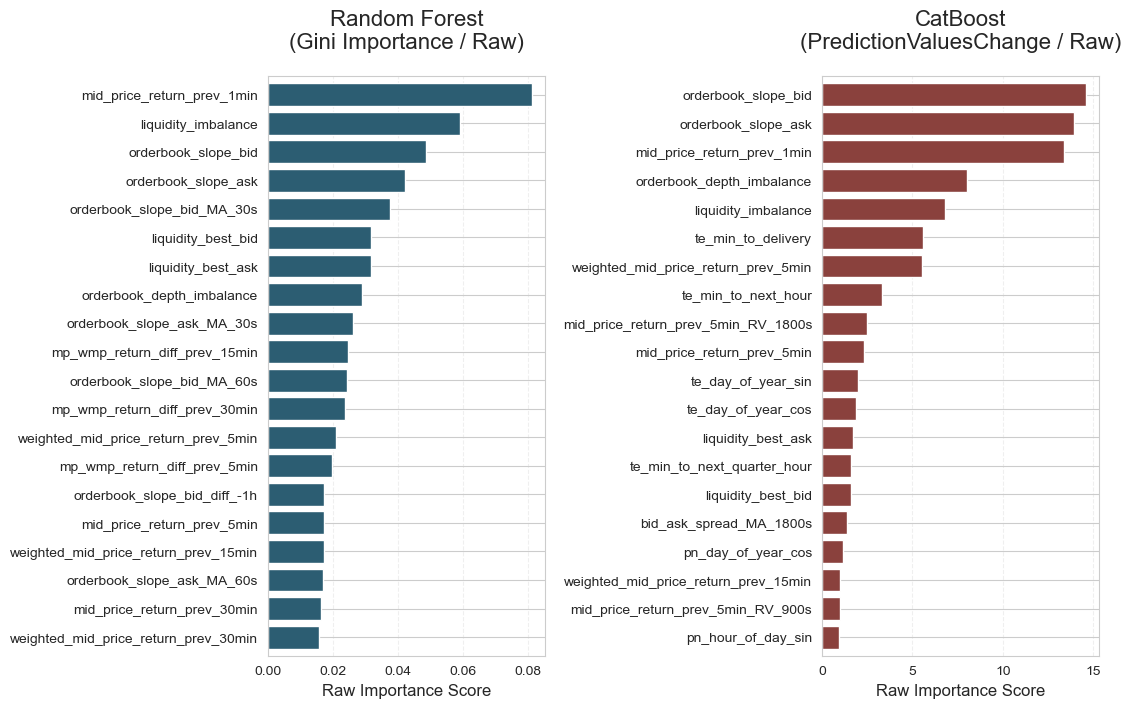

In [9]:
import matplotlib.pyplot as plt
import pandas as pd


def plot_tree_importance_comparison(models_dict, feature_names, feature_limit=15, save_name=None):
    """
    Erstellt einen sauberen Vergleich der intrinsischen Feature Importances
    für RandomForest und CatBoost.
    """
    # Zwei Subplots nebeneinander
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

    # --- 1. RandomForest: Gini Importance ---
    rf_model = models_dict['RandomForest']
    importances_rf = pd.Series(rf_model.feature_importances_, index=feature_names)
    importances_rf = importances_rf.sort_values(ascending=True).tail(feature_limit)

    importances_rf.plot(kind='barh', ax=ax1, color='#2c5d72', width=0.8)
    ax1.set_title("Random Forest\n(Gini Importance / Raw)", fontsize=16, pad=20)
    ax1.set_xlabel("Raw Importance Score", fontsize=12)
    ax1.grid(axis='x', linestyle='--', alpha=0.3)

    # --- 2. CatBoost: Feature Importance ---
    cat_model = models_dict['CatBoost']
    # Nutzt standardmäßig PredictionValuesChange
    importances_cat = pd.Series(cat_model.get_feature_importance(), index=feature_names)
    importances_cat = importances_cat.sort_values(ascending=True).tail(feature_limit)

    importances_cat.plot(kind='barh', ax=ax2, color='#8a413d', width=0.8)
    ax2.set_title("CatBoost\n(PredictionValuesChange / Raw)", fontsize=16, pad=20)
    ax2.set_xlabel("Raw Importance Score", fontsize=12)
    ax2.grid(axis='x', linestyle='--', alpha=0.3)

    # Optimierung der Abstände
    plt.tight_layout(pad=4.0)
    # Falls die Namen immer noch zu nah aneinander sind, hier manuell nachsteuern:
    plt.subplots_adjust(wspace=1)

    if save_name:
        save_plot(fig, save_name, FIGURES_PATH)

    plt.show()


# --- Aufruf ---
# Wir nutzen die Spaltennamen aus deinem Trainingsdatensatz (ohne ttd/metadata)
feature_cols = X_train_clean.columns

models_to_compare = {
    'RandomForest': model_rf,
    'CatBoost': model_cb
}

plot_tree_importance_comparison(models_to_compare, feature_cols, feature_limit=20, save_name="intrinsice_importances")

/var/folders/_g/t9jm9x4n7v313q5_zspldllr0000gn/T/ipykernel_2351/2110719521.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_results['MLP']['values'], shap_results['MLP']['data'], show=False, plot_size=None)
/opt/anaconda3/envs/Masterarbeit/lib/python3.12/site-packages/shap/plots/_beeswarm.py:1150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/_g/t9jm9x4n7v313q5_zspldllr0000gn/T/ipykernel_2351/2110719521.py:25: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_results['RandomForest']['valu

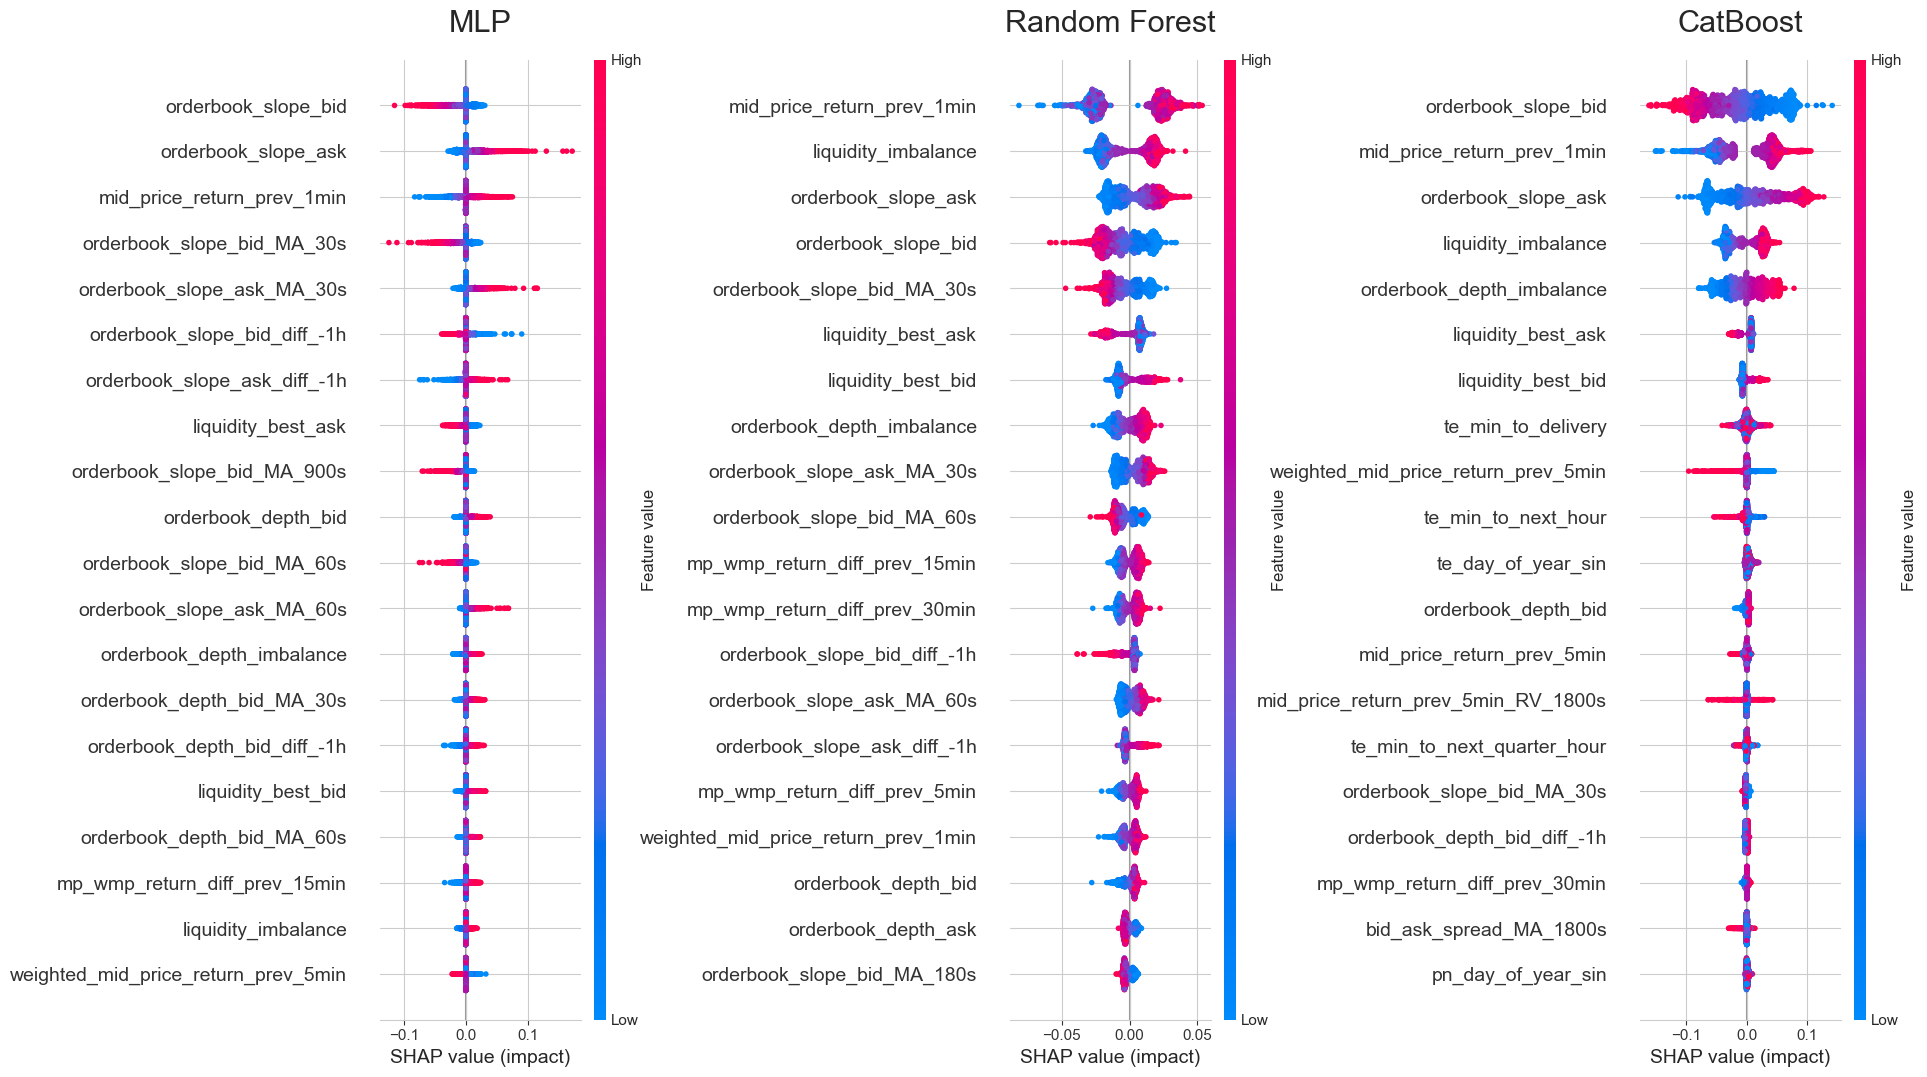

✅ Grafik gespeichert in: figures/blackbox/summary_plots


In [10]:
import matplotlib.pyplot as plt
import shap

# 1. Gigantische Leinwand
fig = plt.figure(figsize=(18, 16))

# 2. Hardcoded Positionen: [Abstand_von_links, Abstand_von_unten, Breite, Höhe]
# Hier definieren wir manuelle "Boxen". Zwischen den Boxen ist leerer Raum erzwungen.
# Plot 1 startet bei 10%, Plot 2 bei 45%, Plot 3 bei 80%.
# Das zwingt riesige Lücken für deine extrem langen Feature-Namen (z.B. "mid_price_return_prev_1min_...") auf.
ax1 = fig.add_axes([0.10, 0.15, 0.14, 0.6])
ax2 = fig.add_axes([0.45, 0.15, 0.14, 0.6])
ax3 = fig.add_axes([0.80, 0.15, 0.14, 0.6])

# --- 1. MLP ---
plt.sca(ax1)
# plot_size=None ist zwingend nötig, sonst formatiert SHAP die Figure heimlich um!
shap.summary_plot(shap_results['MLP']['values'], shap_results['MLP']['data'], show=False, plot_size=None)
ax1.set_title("MLP", fontsize=22, pad=20)
ax1.set_xlabel("SHAP value (impact)", fontsize=14)
ax1.tick_params(axis='y', labelsize=14)

# --- 2. Random Forest ---
plt.sca(ax2)
shap.summary_plot(shap_results['RandomForest']['values'], shap_results['RandomForest']['data'], show=False,
                  plot_size=None)
ax2.set_title("Random Forest", fontsize=22, pad=20)
ax2.set_xlabel("SHAP value (impact)", fontsize=14)
ax2.tick_params(axis='y', labelsize=14)

# --- 3. CatBoost ---
plt.sca(ax3)
shap.summary_plot(shap_results['CatBoost']['values'], shap_results['CatBoost']['data'], show=False, plot_size=None)
ax3.set_title("CatBoost", fontsize=22, pad=20)
ax3.set_xlabel("SHAP value (impact)", fontsize=14)
ax3.tick_params(axis='y', labelsize=14)

plt.show()

save_plot(fig, "summary_plots", FIGURES_PATH)

✅ Grafik gespeichert in: figures/blackbox/fixed_dependence_with_auto_interactions


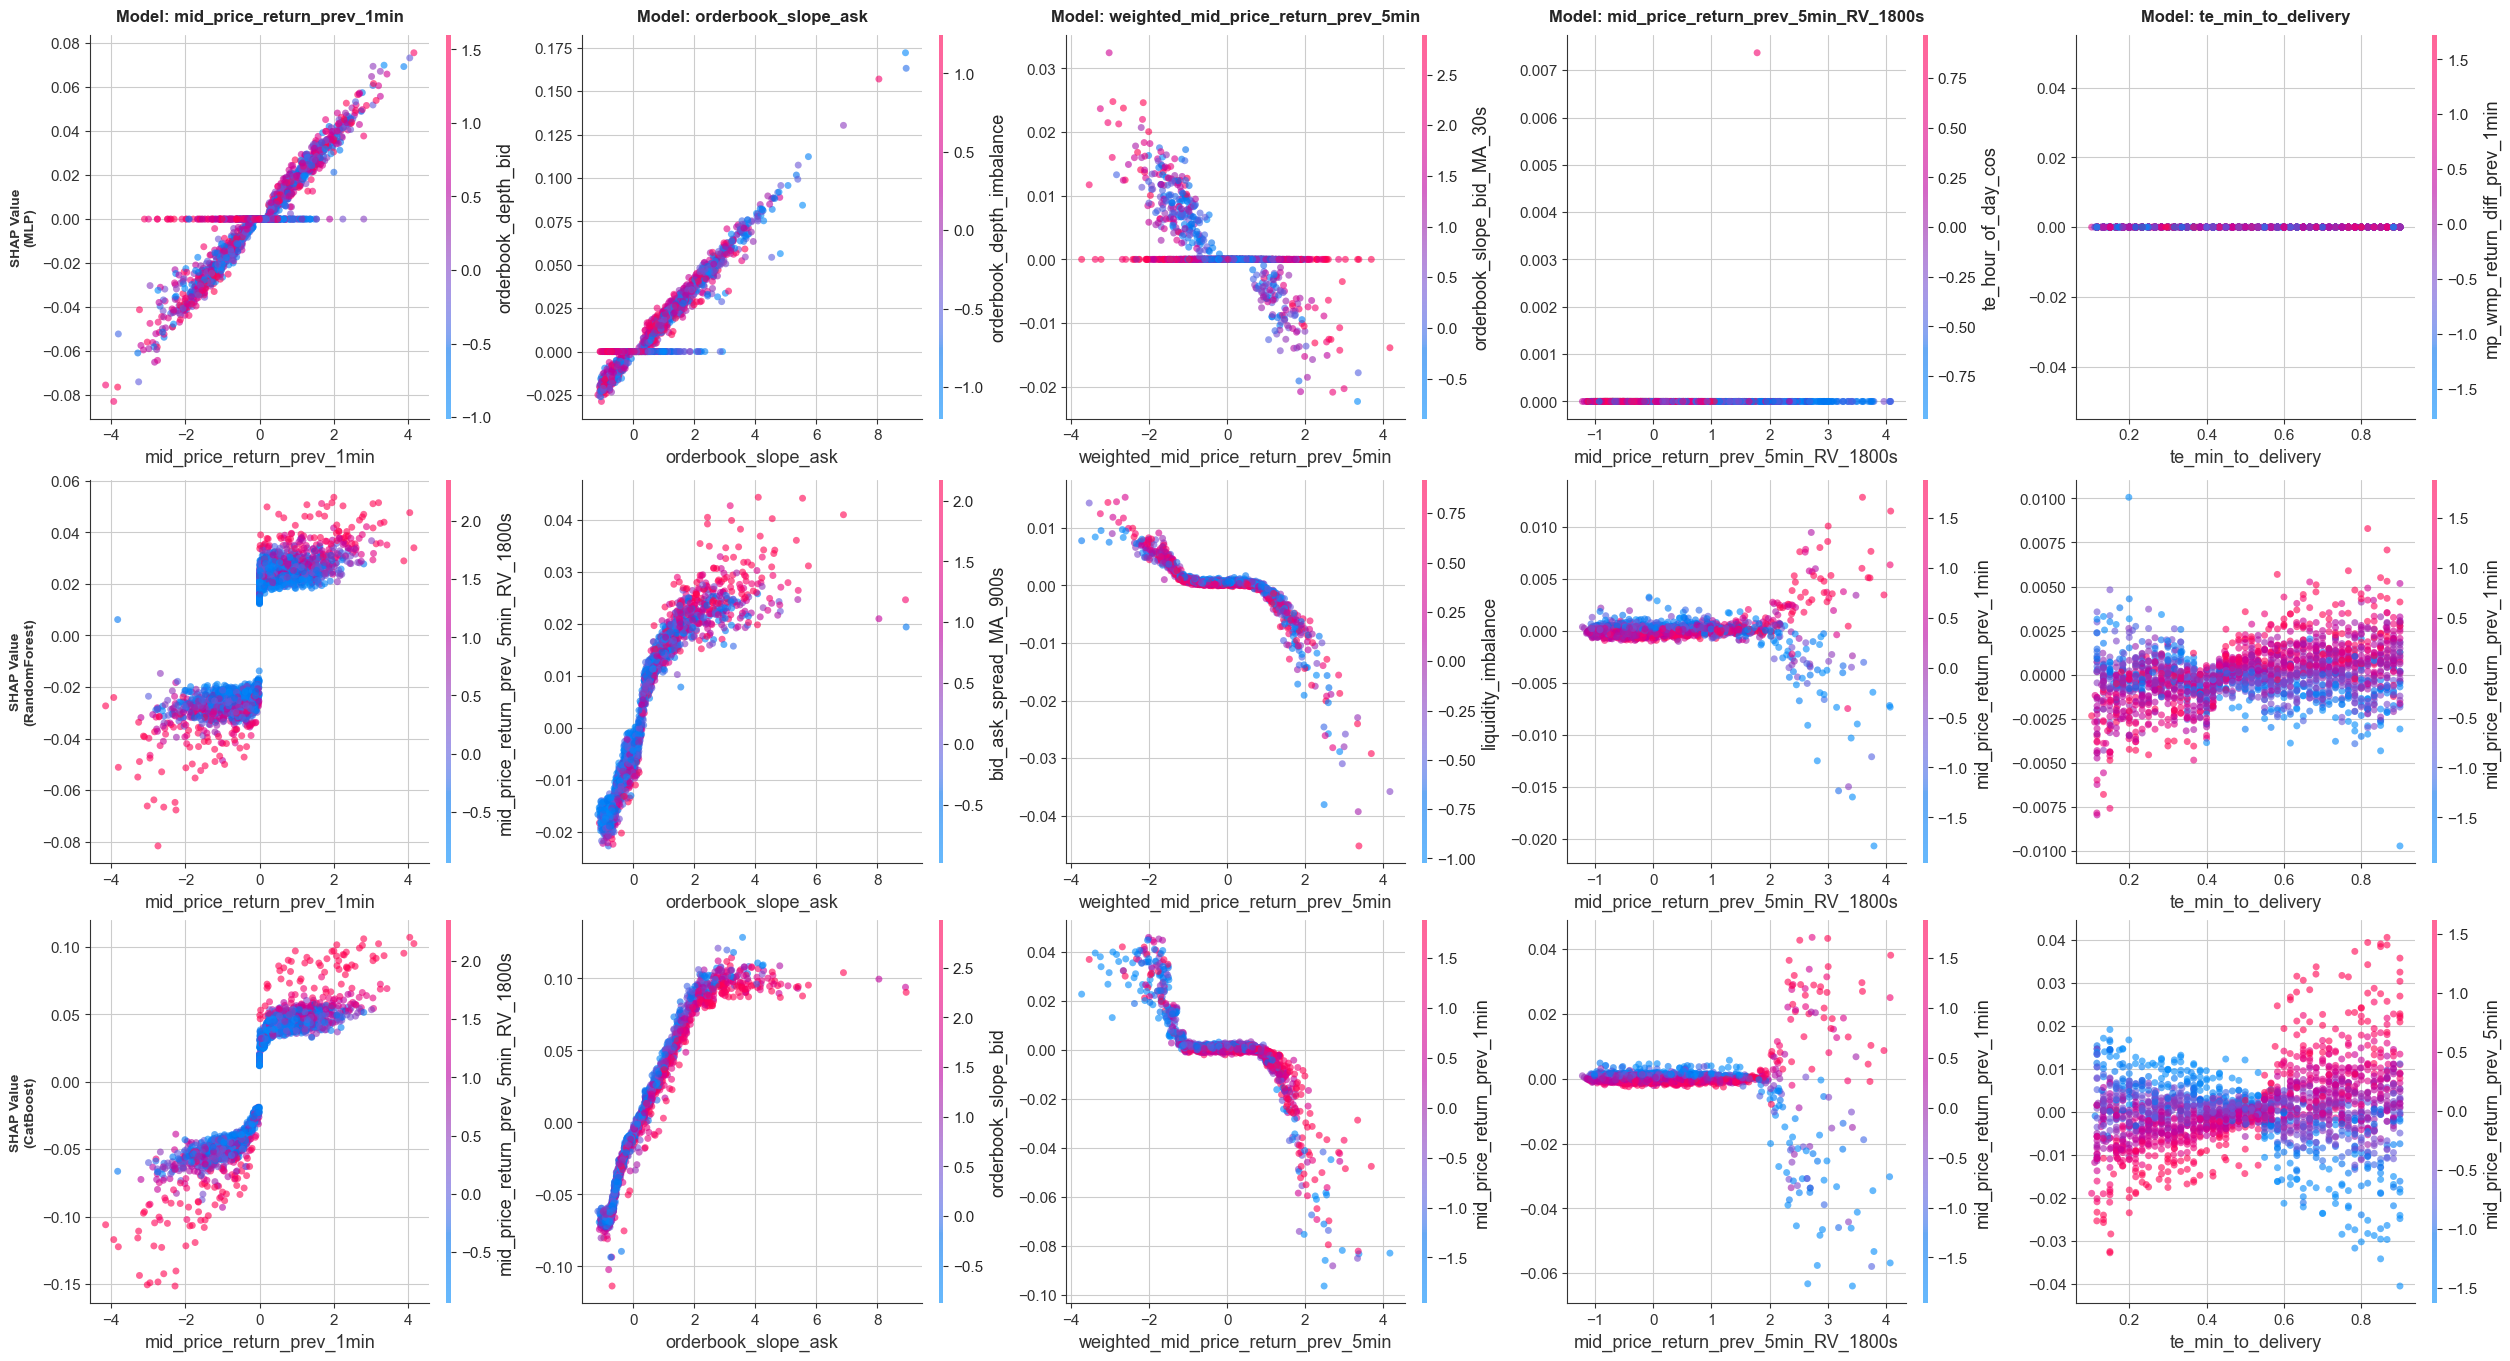

In [11]:
import matplotlib.pyplot as plt
import shap
import numpy as np


def plot_linearity_and_interaction_comparison(shap_results, target_features, transpose=True, save_name=None):
    """
    Erstellt eine Matrix zur Analyse der Linearität UND Interaktion.
    Nutzt die Farbskala für das Feature mit der stärksten Interaktion.
    """
    models = list(shap_results.keys())
    num_models = len(models)
    num_features = len(target_features)

    # Grid-Dimensionen basierend auf Transponierung
    if transpose:
        n_rows, n_cols = num_features, num_models
        row_labels, col_labels = target_features, models
    else:
        n_rows, n_cols = num_models, num_features
        row_labels, col_labels = models, target_features

    # Größeres figsize für die Farbskalen (Colorbars)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4.5 * n_rows), constrained_layout=True)

    if n_rows == 1: axes = np.expand_dims(axes, axis=0)
    if n_cols == 1: axes = np.expand_dims(axes, axis=1)

    for r in range(n_rows):
        for c in range(n_cols):
            ax = axes[r, c]

            model_name = col_labels[c] if transpose else row_labels[r]
            feat_name = row_labels[r] if transpose else col_labels[c]

            res = shap_results[model_name]
            sv = res['values']
            df = res['data']

            if isinstance(sv, shap.Explanation):
                feature_names = sv.feature_names
                values_to_plot = sv.values
                input_data = sv.data
            else:
                feature_names = list(df.columns)
                values_to_plot = sv
                input_data = df.values

            if feat_name in feature_names:
                feat_idx = feature_names.index(feat_name)

                # interaction_index='auto' lässt SHAP das stärkste Interaktions-Feature suchen
                # Die Farbskala wird automatisch rechts neben dem Subplot erzeugt
                shap.dependence_plot(
                    feat_idx,
                    values_to_plot,
                    input_data,
                    feature_names=feature_names,
                    interaction_index='auto',
                    ax=ax,
                    show=False,
                    alpha=0.6,
                    dot_size=25,
                )

                # Dynamische Beschriftung optimieren
                if c == 0:
                    ax.set_ylabel(f"SHAP Value\n({row_labels[r]})", fontsize=10, fontweight='bold')
                else:
                    ax.set_ylabel("")

                if r == 0:
                    ax.set_title(f"Model: {col_labels[c]}", fontsize=12, fontweight="bold", pad=10)
            else:
                ax.text(0.5, 0.5, f"{feat_name}\nnot found", ha='center', va='center')
                ax.axis('off')

    if save_name:
        # Hier plt.savefig nutzen oder deine Utility save_plot
        save_plot(fig, save_name, FIGURES_PATH)

    plt.show()


# Aufruf
plot_linearity_and_interaction_comparison(
    shap_results,
    ["mid_price_return_prev_1min",
     "orderbook_slope_ask",
     "weighted_mid_price_return_prev_5min",
     "mid_price_return_prev_5min_RV_1800s",
     "te_min_to_delivery",
     ],
    transpose=False,  # Features in Zeilen für direkten Modell-Vergleich
    save_name="fixed_dependence_with_auto_interactions"
)

✅ Grafik gespeichert in: figures/blackbox/unique_interactions


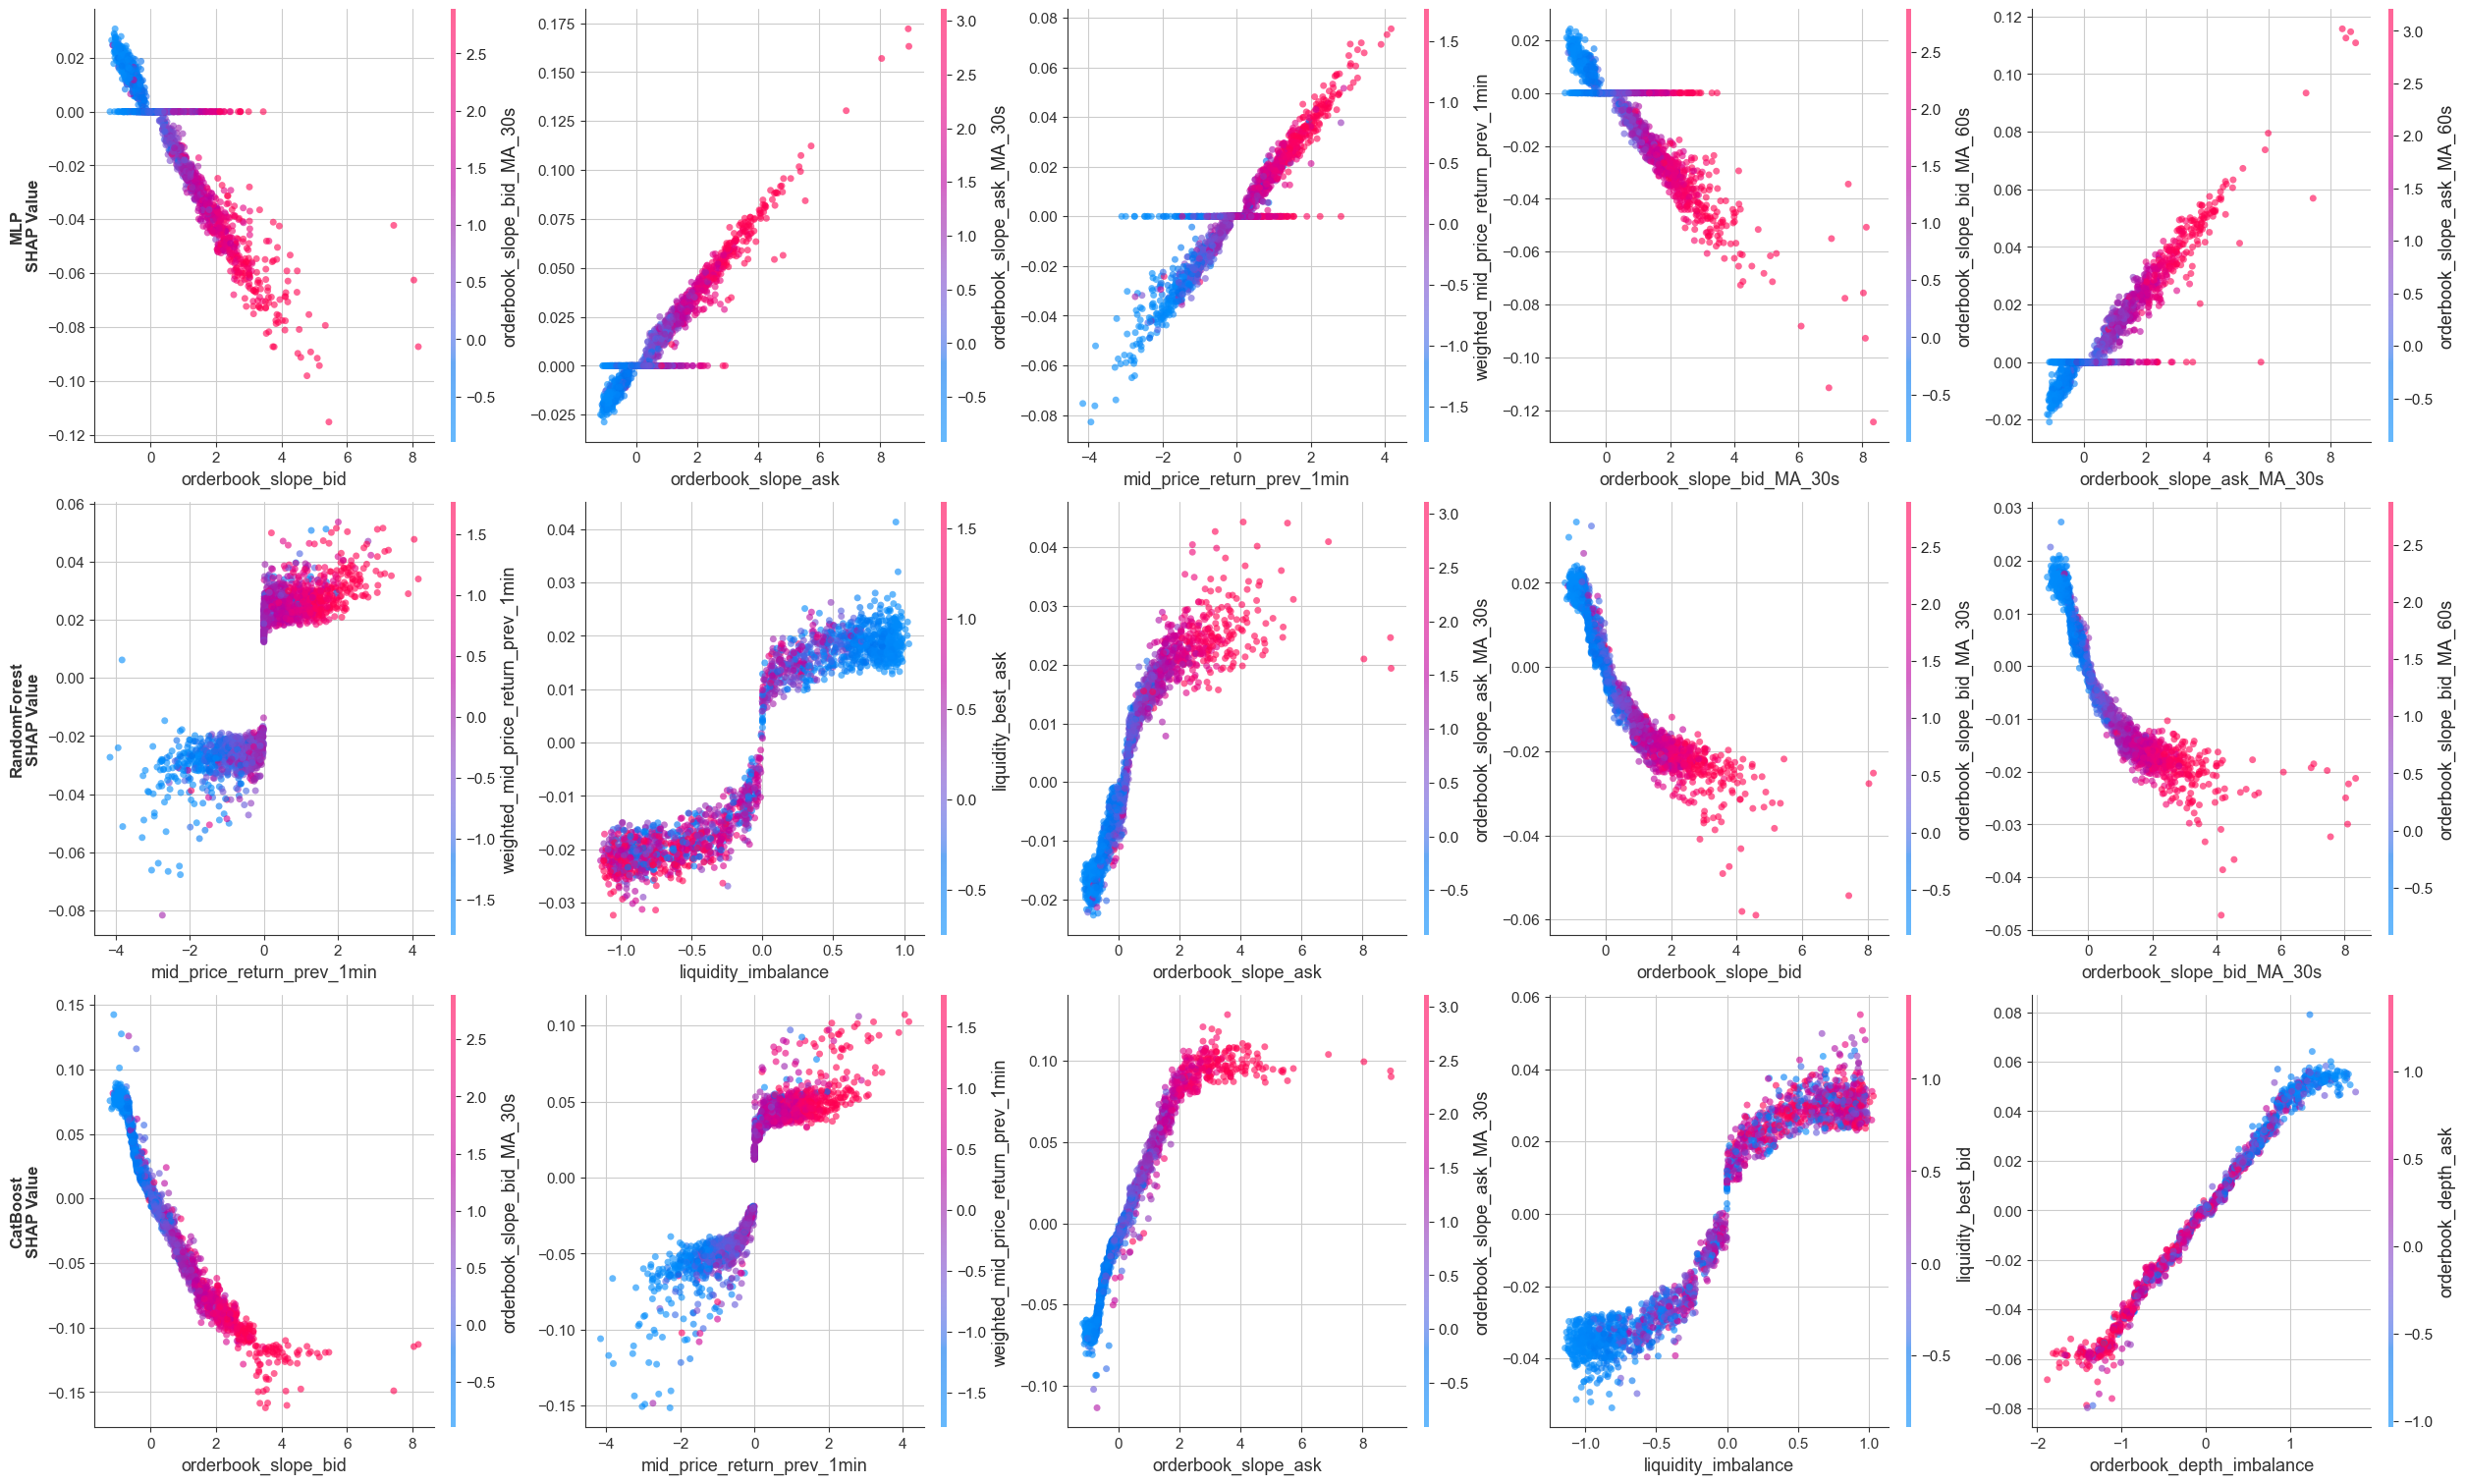

In [12]:
import matplotlib.pyplot as plt
import shap
import numpy as np


def plot_top_unique_interactions_grid(shap_results, top_n=5, save_name=None):
    """
    Erstellt eine Matrix der stärksten EINZIGARTIGEN Interaktionen pro Modell.
    Berechnet Interaktionspartner manuell für maximale Stabilität.
    """
    models = list(shap_results.keys())
    num_models = len(models)

    fig, axes = plt.subplots(num_models, top_n, figsize=(5 * top_n, 5 * num_models), constrained_layout=True)
    if num_models == 1: axes = np.expand_dims(axes, axis=0)

    for row, model_name in enumerate(models):
        res = shap_results[model_name]
        sv = res['values']
        df = res['data']

        if isinstance(sv, shap.Explanation):
            shap_values = sv.values
            feature_names = list(sv.feature_names)
            input_data = sv.data
        else:
            shap_values = sv
            feature_names = list(df.columns)
            input_data = df.values

        # 1. Wichtigkeit berechnen
        mean_abs_shap = np.abs(shap_values).mean(axis=0)
        sorted_indices = np.argsort(mean_abs_shap)[::-1]

        displayed_pairs = set()
        col = 0
        idx_pointer = 0

        while col < top_n and idx_pointer < len(sorted_indices):
            feat_idx = sorted_indices[idx_pointer]
            feat_name = feature_names[feat_idx]

            # 2. Den stärksten Interaktionspartner manuell finden
            # Wir suchen das Feature, das die größte Varianz in den SHAP-Werten von feat_idx erklärt
            potential_interactions = []
            for other_idx in range(len(feature_names)):
                if other_idx == feat_idx: continue
                # Korrelation zwischen SHAP-Wert von A und Merkmalswert von B
                corr = np.abs(np.corrcoef(shap_values[:, feat_idx], input_data[:, other_idx])[0, 1])
                potential_interactions.append((other_idx, corr))

            # Sortieren nach höchster Korrelation
            inter_idx = sorted(potential_interactions, key=lambda x: x[1], reverse=True)[0][0]
            inter_name = feature_names[inter_idx]

            # 3. Dubletten-Check
            current_pair = tuple(sorted((feat_name, inter_name)))

            if current_pair not in displayed_pairs:
                ax = axes[row, col]

                # Plotting mit dem explizit gefundenen Partner
                shap.dependence_plot(
                    feat_idx,
                    shap_values,
                    input_data,
                    feature_names=feature_names,
                    interaction_index=inter_idx,
                    ax=ax,
                    show=False,
                    alpha=0.6,
                    dot_size=25
                )

                if col == 0:
                    ax.set_ylabel(f"{model_name}\nSHAP Value", fontsize=12, fontweight='bold')
                else:
                    ax.set_ylabel("")

                displayed_pairs.add(current_pair)
                col += 1

            idx_pointer += 1

    if save_name:
        save_plot(fig, save_name, FIGURES_PATH)
    plt.show()


# Aufruf
plot_top_unique_interactions_grid(shap_results, top_n=5, save_name="unique_interactions")

In [13]:
import numpy as np
import time
from joblib import Parallel, delayed


def calculate_batch(explainer, data_batch):
    # Diese Funktion läuft in einem eigenen Prozess
    return explainer.shap_interaction_values(data_batch)


def enrich_rf_interactions_parallel(shap_results, model_name, max_samples=300, top_k=20, n_jobs=-1):
    res = shap_results[model_name]
    explainer = res['explainer']
    data = res['data']

    # Top-K Logik (bleibt gleich)
    vals = res['values']
    mean_abs_shap = np.abs(vals).mean(axis=0)
    top_indices = np.argsort(mean_abs_shap)[-top_k:]
    top_feature_names = data.columns[top_indices].tolist()

    n_samples = min(len(data), max_samples)
    calculation_data = data.sample(n_samples, random_state=42)[top_feature_names]

    print(f">>> [RF Parallel] Calculating {n_samples} samples on {n_jobs} cores...")
    start_time = time.time()

    try:
        # Split data into chunks for each CPU core
        # Wir teilen die Daten in n_jobs Teile auf
        num_cores = Parallel(n_jobs=n_jobs)._effective_n_jobs()
        chunks = np.array_split(calculation_data, num_cores)

        # Parallel Ausführung
        results = Parallel(n_jobs=n_jobs)(
            delayed(calculate_batch)(explainer, chunk) for chunk in chunks
        )

        # Ergebnisse wieder zusammenfügen (Stacking entlang der Sample-Achse)
        interactions = np.concatenate(results, axis=0)

        res['interaction_values'] = interactions
        res['interaction_data'] = calculation_data
        res['interaction_features'] = top_feature_names

        print(f"--- RF Parallel finished in {time.time() - start_time:.2f}s ---")
    except Exception as e:
        print(f"!!! RF Error: {e}")

    return shap_results


shap_results = enrich_rf_interactions_parallel(shap_results, "RandomForest", max_samples=500, top_k=30, n_jobs=-1)

>>> [RF Parallel] Calculating 500 samples on -1 cores...


/opt/anaconda3/envs/Masterarbeit/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


--- RF Parallel finished in 201.49s ---


In [14]:
import time


def enrich_catboost_interactions(shap_results, model_name, max_samples=300, top_k=20):
    """Spezifisch für CatBoost: Erhält Feature-Reihenfolge."""
    res = shap_results[model_name]
    explainer = res['explainer']
    data = res['data']  # Original mit allen Spalten

    # 1. Top-K bestimmen
    vals = res['values'].values if hasattr(res['values'], 'values') else res['values']
    mean_abs_shap = np.abs(vals).mean(axis=0)
    top_indices = np.argsort(mean_abs_shap)[-top_k:]
    top_feature_names = data.columns[top_indices].tolist()

    start_time = time.time()
    try:
        n_samples = min(len(data), max_samples)
        calculation_data = data.sample(n_samples, random_state=42)

        print(f">>> [CatBoost] Calculating for {n_samples} samples (full feature set)...")
        # CatBoost braucht zwingend alle Spalten in korrekter Reihenfolge
        interactions = explainer.shap_interaction_values(calculation_data)

        # Erst nach der Berechnung auf Top-K zuschneiden
        reduced_interactions = interactions[:, top_indices, :][:, :, top_indices]

        res['interaction_values'] = reduced_interactions
        res['interaction_data'] = calculation_data[top_feature_names]
        res['interaction_features'] = top_feature_names

        print(f"--- CatBoost finished in {time.time() - start_time:.2f}s ---")
    except Exception as e:
        print(f"!!! CatBoost Error: {e}")
    return shap_results


shap_results = enrich_catboost_interactions(shap_results, model_name='CatBoost', max_samples=500, top_k=30)

>>> [CatBoost] Calculating for 500 samples (full feature set)...
--- CatBoost finished in 45.50s ---


✅ Grafik gespeichert in: figures/blackbox/interaction_heatmaps


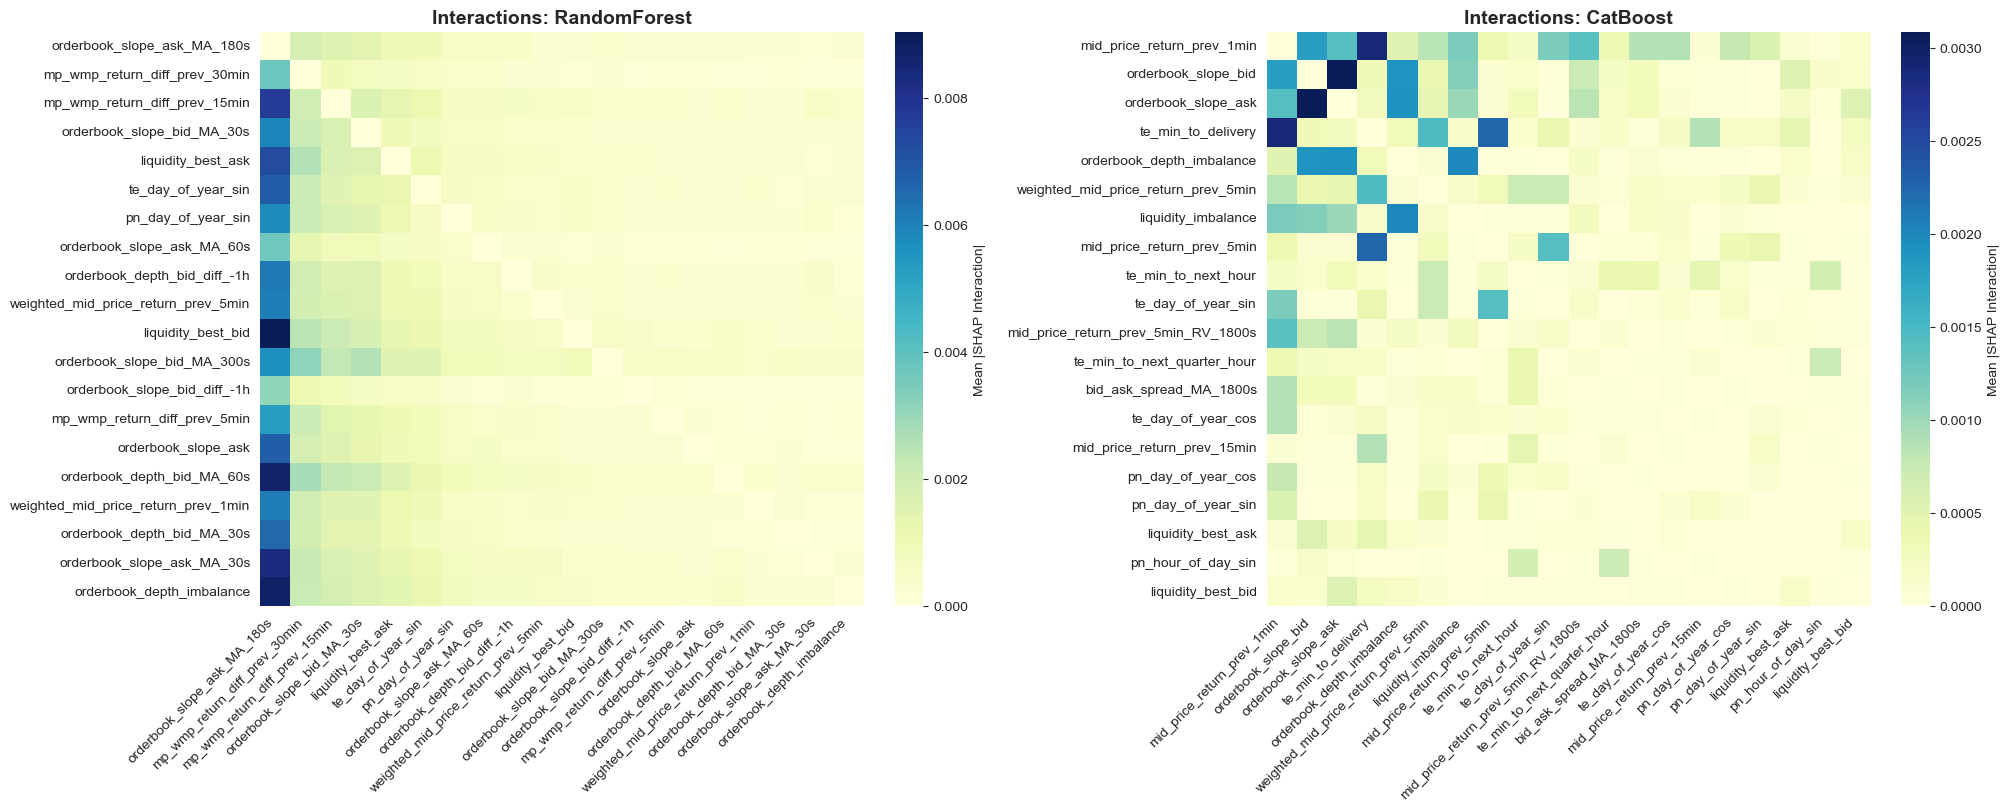

In [15]:
import seaborn as sns


def plot_interaction_heatmaps(shap_results, top_n=8, save_name=None):
    """
    Plottet die Heatmaps basierend auf den angereicherten Interaction Values.
    Berücksichtigt reduzierte Top-K Matrizen.
    """
    # Nur Modelle plotten, die Interaktionsdaten haben
    valid_models = [m for m in shap_results.keys() if 'interaction_values' in shap_results[m]]
    num_models = len(valid_models)

    if num_models == 0:
        print("No interactions found in shap_results.")
        return

    fig, axes = plt.subplots(1, num_models, figsize=(10 * num_models, 8), constrained_layout=True)
    if num_models == 1: axes = [axes]

    for i, model_name in enumerate(valid_models):
        res = shap_results[model_name]
        ax = axes[i]

        inter_val = res['interaction_values']

        # 1. Die richtigen Feature-Namen bestimmen
        # Falls wir die Top-K Funktion genutzt haben, stehen die Namen in 'interaction_features'
        if 'interaction_features' in res:
            feature_names = res['interaction_features']
        else:
            feature_names = res['data'].columns

        # 2. Matrix extrahieren
        matrix = np.abs(inter_val.values).mean(0) if hasattr(inter_val, "values") else np.abs(inter_val).mean(0)
        # matrix = (matrix + matrix.T) / 2

        # 3. Diagonale auf 0
        np.fill_diagonal(matrix, 0)

        # 4. DataFrame erstellen (jetzt passen Matrix-Shape und Index-Länge zusammen)
        df_inter = pd.DataFrame(matrix, index=feature_names, columns=feature_names)

        # 5. Filter auf die Top N Features innerhalb dieser Matrix
        top_feats = df_inter.sum().sort_values(ascending=False).head(top_n).index
        df_plot = df_inter.loc[top_feats, top_feats]

        # 6. Plotting
        sns.heatmap(df_plot, annot=False, fmt=".4f", cmap="YlGnBu", ax=ax,
                    cbar_kws={'label': 'Mean |SHAP Interaction|'})

        ax.set_title(f"Interactions: {model_name}", fontsize=14, fontweight='bold')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    if save_name:
        save_plot(fig, save_name, FIGURES_PATH)
    plt.show()


# Aufruf
plot_interaction_heatmaps(shap_results, top_n=20, save_name="interaction_heatmaps")

✅ Grafik gespeichert in: figures/blackbox/pure_interaction_values_grid


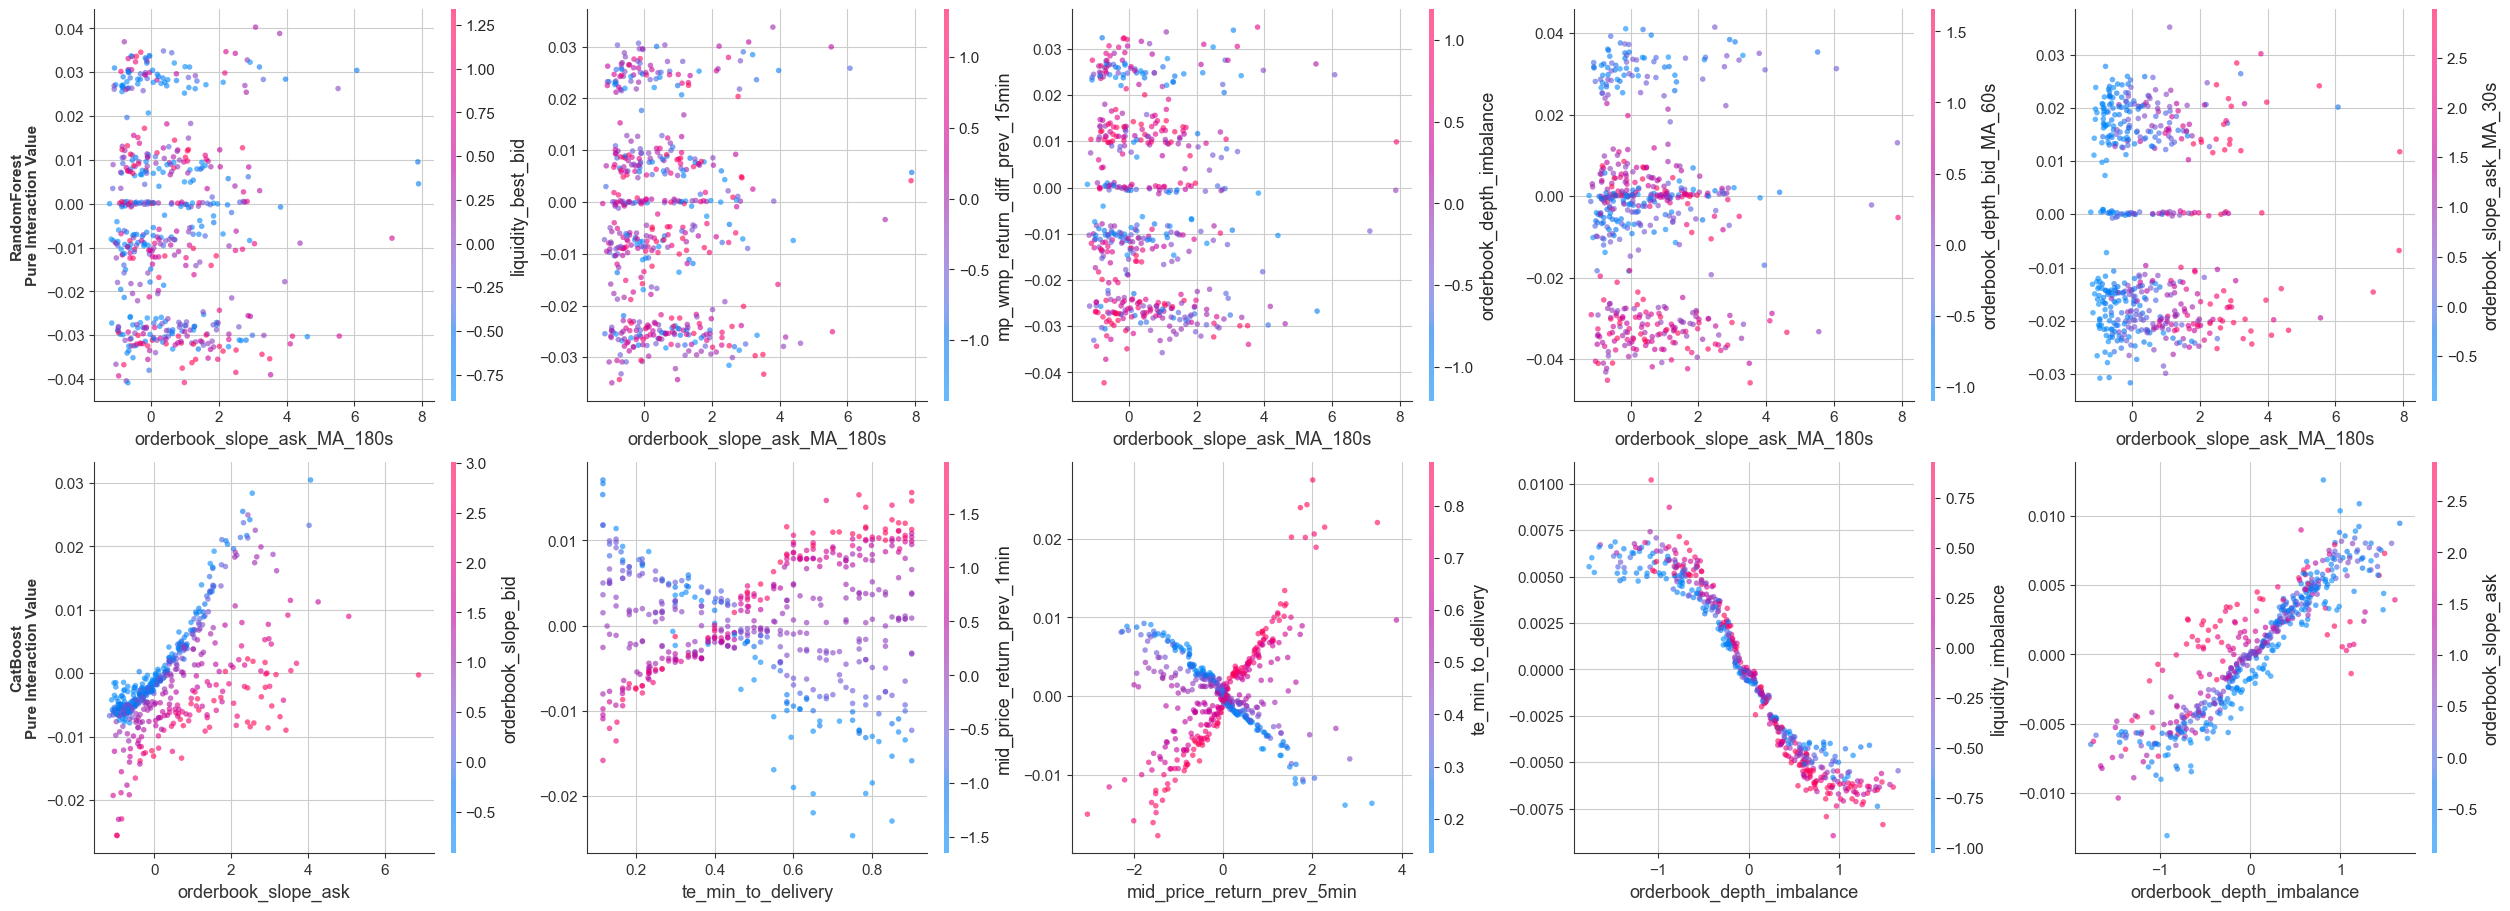

In [16]:
import matplotlib.pyplot as plt
import shap
import numpy as np
import pandas as pd


def plot_top_pure_interactions_grid(shap_results, top_n=5, save_name=None):
    """
    Plottet ein Grid (Modelle x Top N Interaktionen) mit den REINEN Interaction Values.
    Y-Achse: SHAP Interaction Value (Synergie-Effekt).
    """
    # Nur Modelle nehmen, die die Interaktions-Matrix berechnet haben (Trees)
    valid_models = [m for m in shap_results.keys() if 'interaction_values' in shap_results[m]]
    num_models = len(valid_models)

    if num_models == 0:
        print("Keine Interaktionsdaten gefunden. Bitte zuerst enrich_results laufen lassen.")
        return

    # Grid erstellen
    fig, axes = plt.subplots(num_models, top_n, figsize=(5 * top_n, 4.5 * num_models), constrained_layout=True)
    if num_models == 1: axes = np.expand_dims(axes, axis=0)

    for row, model_name in enumerate(valid_models):
        res = shap_results[model_name]

        # Werte und Datenstruktur laden
        inter_vals = res['interaction_values']
        data = res.get('interaction_data', res['data'])

        # Entweder die zugeschnittenen Features (Top K) oder alle
        feature_names = res.get('interaction_features', data.columns.tolist())

        # 1. Matrix berechnen und symmetrisieren (wie besprochen!)
        vals = inter_vals.values if hasattr(inter_vals, "values") else inter_vals
        matrix = np.abs(vals).mean(axis=0)
        matrix = (matrix + matrix.T) / 2
        np.fill_diagonal(matrix, 0)  # Haupteffekte ignorieren

        # 2. Die Top N Paare finden (ohne Dubletten)
        # Wir nehmen nur das "obere Dreieck" der Matrix, da (A,B) gleich (B,A) ist
        upper_tri_indices = np.triu_indices_from(matrix, k=1)
        upper_tri_values = matrix[upper_tri_indices]

        # Sortieren (die höchsten Werte zuerst) und die Top N Indizes holen
        top_sorted_idx = np.argsort(upper_tri_values)[::-1][:top_n]

        # Zurückübersetzen in 2D Koordinaten (Feature i, Feature j)
        top_pairs = [(upper_tri_indices[0][idx], upper_tri_indices[1][idx]) for idx in top_sorted_idx]

        # 3. Plotten
        for col, (i, j) in enumerate(top_pairs):
            ax = axes[row, col]

            # WICHTIG: Durch die Übergabe als Tuple (i, j) weiß SHAP,
            # dass es den REINEN Interaktionswert aus dem 3D-Array plotten soll.
            shap.dependence_plot(
                (i, j),
                vals,
                data,
                feature_names=feature_names,
                ax=ax,
                show=False,
                alpha=0.6,
                dot_size=20
            )

            # Kosmetik für die Thesis
            if col == 0:
                ax.set_ylabel(f"{model_name}\nPure Interaction Value", fontsize=11, fontweight='bold')
            else:
                ax.set_ylabel("")

    if save_name:
        save_plot(fig, save_name, FIGURES_PATH)
    plt.show()


# Aufruf
plot_top_pure_interactions_grid(shap_results, top_n=5, save_name="pure_interaction_values_grid")

✅ Grafik gespeichert in: figures/blackbox/decision_20_extremes


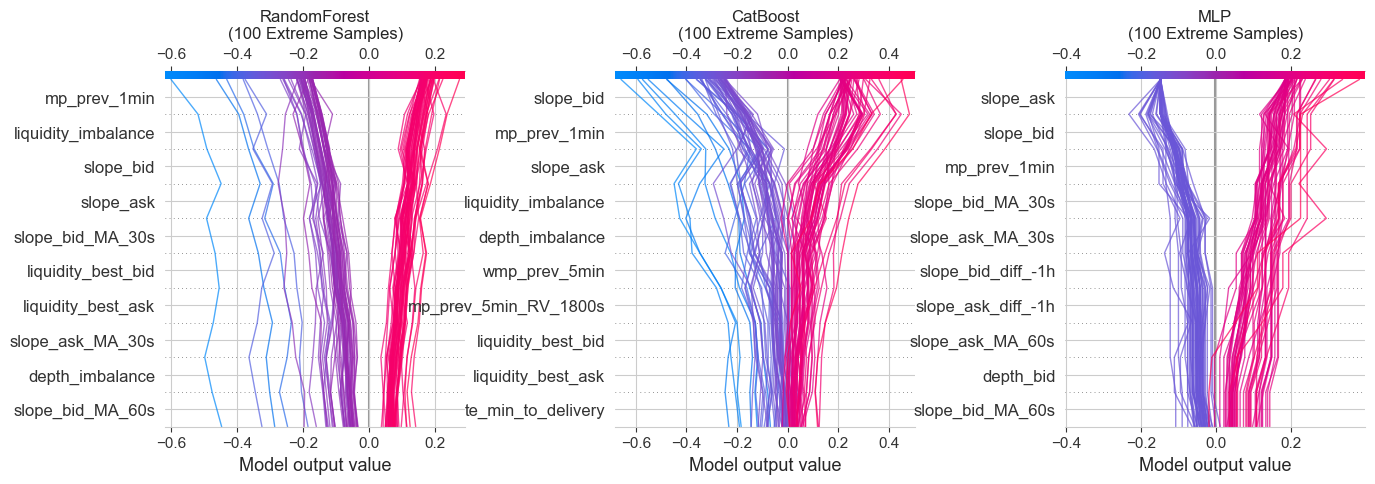

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap


def compare_model_extreme_paths(shap_results, model_names, n_extreme=5, max_features=20, save_name=None):
    """
    Plottet für jedes Modell die n_extreme höchsten UND n_extreme niedrigsten
    Vorhersagen nebeneinander.
    """
    n_models = len(model_names)

    # Massive Breite: 12 Zoll pro Modell
    fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, max_features * 0.3 + 1))

    if n_models == 1:
        axes = [axes]

    for i, m_name in enumerate(model_names):
        res = shap_results[m_name]
        explainer = res['explainer']
        shap_vals = res['values']
        data = res['data'].copy()

        # Feature Namen kürzen für mehr Platz
        data.columns = [
            c.replace('orderbook_', '').replace("weighted_mid_price", "wmp").replace("mid_price", "mp").replace(
                "_return_", "_") for
            c in data.columns]

        # Base Value holen
        base_value = explainer.expected_value
        if isinstance(base_value, (list, np.ndarray)):
            base_value = base_value[0]

        vals = shap_vals.values if hasattr(shap_vals, 'values') else shap_vals
        predicted_values = base_value + vals.sum(axis=1)

        # Die n größten und n kleinsten Indizes finden
        idx_max = np.argsort(predicted_values)[-n_extreme:]  # Top n
        idx_min = np.argsort(predicted_values)[:n_extreme]  # Flop n
        combined_indices = np.concatenate([idx_min, idx_max])  # Zusammenführen

        plt.sca(axes[i])

        # Decision Plot für die kombinierten Extreme
        shap.decision_plot(
            base_value,
            vals[combined_indices],
            features=data.iloc[combined_indices],
            feature_names=data.columns.tolist(),
            show=False,
            title=f"{m_name}\n({n_extreme * 2} Extreme Samples)",
            alpha=0.7,
            auto_size_plot=False,
            feature_display_range=slice(None, -max_features - 1, -1)  # Hier wird begrenzt
        )

        axes[i].tick_params(axis='y', labelsize=12)

    # Ränder optimieren, damit die Plot-Area maximal breit ist
    plt.subplots_adjust(left=0.1, right=0.9, wspace=0.5, top=1)

    if save_name:
        save_plot(fig, save_name, FIGURES_PATH)

    plt.show()


# --- ANWENDUNG ---
# Zeigt pro Modell die 5 extremsten Long- und Short-Szenarien
compare_model_extreme_paths(shap_results, ["RandomForest", "CatBoost", "MLP"], n_extreme=50, max_features=10,
                            save_name="decision_20_extremes")

✅ Grafik gespeichert in: figures/blackbox/example_waterfall_CatBoost


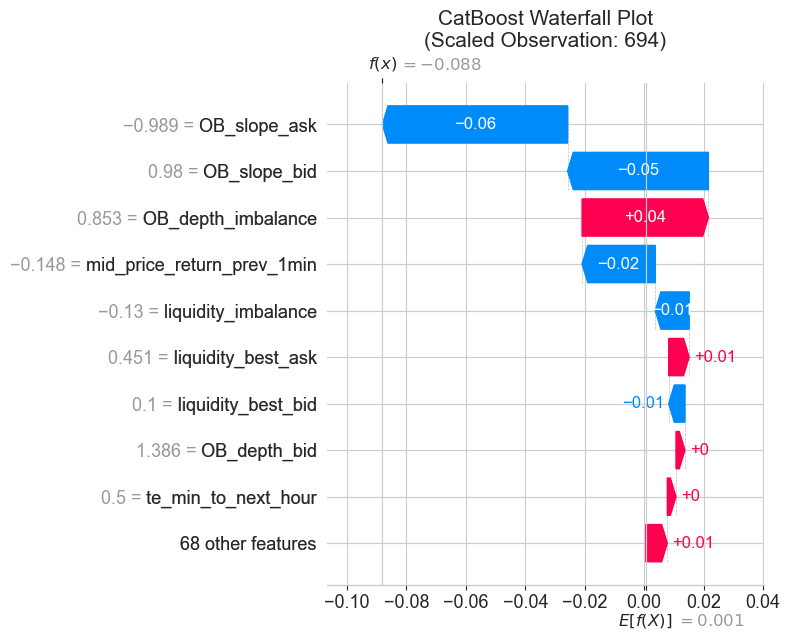

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import shap


def compare_extreme_waterfalls(shap_results, model_name, save_name=None):
    res = shap_results[model_name]
    vals = res['values'].values if hasattr(res['values'], 'values') else res['values']
    data = res['data']

    # Feature Namen kürzen
    short_names = [c.replace('orderbook_', 'OB_').replace('_MA_', '_') for c in data.columns]

    base_val = res['explainer'].expected_value
    if isinstance(base_val, (list, np.ndarray)):
        base_val = base_val[0]

    total_impact = vals.sum(axis=1)
    idx_max = np.argmax(total_impact)
    idx_min = np.argmin(total_impact)
    idx_random = np.random.choice(np.where(np.abs(total_impact - base_val) < 0.01)[0])
    idx_static = 694

    idx = idx_static

    # Lösung für die Größe: Wir erstellen die Figure und geben die Breite vor
    fig = plt.figure(figsize=(20, 8))  # Hier steuerst du die Gesamtgröße

    # Bearish Plot
    exp_min = shap.Explanation(
        values=vals[idx],
        base_values=base_val,
        data=data.iloc[idx].values,
        feature_names=short_names
    )
    shap.plots.waterfall(exp_min, show=False)
    plt.title(f"{model_name} Waterfall Plot\n(Scaled Observation: {idx})", fontsize=15)

    plt.tight_layout()

    if save_name:
        save_plot(fig, save_name, FIGURES_PATH)

    plt.show()


model_name = "CatBoost"
compare_extreme_waterfalls(shap_results, model_name, save_name=f"example_waterfall_{model_name}")